In [2]:
import sys
import pathlib
from os import uname
import json

import numpy as np
import ROOT as rt
from math import ceil, floor
import numba as nb

from src.muon_system import MuonSystemAwkward
from src import CMS_lumi, tdrstyle
from src.helper_functions import alert, Table  # , canvas
from src.histo_utilities import create_TH1D, create_TH2D, create_TGraph, std_color_list

from histo_skim import (
    create_hists,
    ROOT_ERROR_LEVEL,
    DATA_VERSION,
    LUMI,
    FN_MC,
    FN_R3,
    T2_OUT_DIR,
    T2_DATA_DIR,
    LOCAL_OUT_DIR,
    LOCAL_DATA_DIR,
    OUT_DIR,
    DATA_DIR,
    gc,
    ABCD_DTSIZE,
    ABCD_DPHI,
    TOP_MARGIN,
    BOT_MARGIN,
    CUTS,
)

# from sklearn.metrics import roc_auc_score  # , roc_curve
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.ensemble import GradientBoostingClassifier  # , RandomForestClassifier

# **************************** #
if "TIER2" in DATA_DIR:
    OUT_DIR = f"{T2_OUT_DIR}/{OUT_DIR}"

    FN_MC = f"{T2_DATA_DIR}/MC_Summer22EE/v1/sixie/v{DATA_VERSION}/normalized/{FN_R3}.root"
    FN_R3 = f"{T2_DATA_DIR}/Data2022/v{DATA_VERSION}/normalized/{FN_R3}.root"

    FN_HLT_MC = f"{LOCAL_DATA_DIR}/../processed/mc_hlt569.root" #! BROKEN
    FN_HLT_R3 = f"{LOCAL_DATA_DIR}/../processed/r3_hlt569.root" #! BROKEN
else:
    OUT_DIR = f"{LOCAL_OUT_DIR}/{OUT_DIR}"

    FN_MC = f"{LOCAL_DATA_DIR}/{FN_MC}_v{DATA_VERSION}.root"
    FN_R3 = f"{LOCAL_DATA_DIR}/{FN_R3}_v{DATA_VERSION}.root"

    FN_HLT_MC = f"{LOCAL_DATA_DIR}/../processed/mc_hlt569.root"
    FN_HLT_R3 = f"{LOCAL_DATA_DIR}/../processed/r3_hlt569.root"

pathlib.Path(OUT_DIR).mkdir(parents=True, exist_ok=True)
# **************************** #
rt.gErrorIgnoreLevel = ROOT_ERROR_LEVEL
# rt.gROOT.SetBatch(True)
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0
# **************************** #

Welcome to JupyROOT 6.30/02


In [26]:
N_EVENTS = -1
CUTS = [
    "match",
    "HLT", #! Loading TBranch HLTDecision causes memory overflow so I use second precut TTree
    # "CSC&DT>0",
    "L1",
    # "CSCIT",
    # "DTIT",
    "MET",
    # "ME11/12",
    # "MB1",
    # "JET",
    # "MUON",
    # "BDT",
    # "HALO",
    # "CSCSIZE",
    # "DTSTN",
    "1CSC1DT",
    # "BLINDSR",
    # "DR",
    "DPHI",
]

if "HLT" in CUTS:
    ff_mc, ff_r3 = FN_MC, FN_HLT_R3
else:
    ff_mc, ff_r3 = FN_MC, FN_R3

# **** #

ms_mc = MuonSystemAwkward(ff_mc, tree_name="MuonSystem", name="Signal", nev=N_EVENTS, is_mc=True, lumi=LUMI)
ms_r3_dtit = MuonSystemAwkward(ff_r3, tree_name="MuonSystem_HLT569", name="Data", nev=N_EVENTS, is_mc=False, lumi=LUMI)
# ms_r3_dtit = MuonSystemAwkward(ff_r3, tree_name="MuonSystem_HLT569", name="Data, DT IT", nev=N_EVENTS, is_mc=False, lumi=LUMI)
# ms_r3_dtoot = MuonSystemAwkward(ff_r3, tree_name="MuonSystem_HLT569", name="Data, DT OOT", nev=N_EVENTS, is_mc=False, lumi=LUMI)

# ms_mc = MuonSystemAwkward(FN_MC, name="Signal, Muon Vetoes", nev=N_EVENTS, is_mc=True, lumi=LUMI)
# ms_r3_other = MuonSystemAwkward(FN_R3, name="Data, DT IT + Muon Vetoes", nev=N_EVENTS, is_mc=False, lumi=LUMI)
# ms_mc = MuonSystemAwkward(FN_MC, name="Signal, Jet Vetoes", nev=N_EVENTS, is_mc=True, lumi=LUMI)
# ms_r3_other = MuonSystemAwkward(FN_R3, name="Data, DT IT + Jet Vetoes", nev=N_EVENTS, is_mc=False, lumi=LUMI)

mss = [ms_mc, ms_r3_dtit]
# mss = [ms_mc, ms_r3_dtoot]
# mss = [ms_mc, ms_r3_dtit, ms_r3_dtoot]

# **** #
print("")
names = [ms.name for ms in mss]
for ims, ms in enumerate(mss):
    # !!! #
    ms.cut = False
    # !!! #
    msn, is_mc = ms.name.lower(), ms.is_mc
    for cut in CUTS:
        match cut:
            case "match":
                if is_mc:
                    ms.match_mc("csc,dt", has_clusters=True)
            case "HLT":
                # if not is_mc:
                #     ms.cut_hlt()
                pass  #! Loading TBranch HLTDecision causes memory overflow so I use a precut TTree
            case "CSC&DT>0":
                ms.f((ms["nCsc"] > 0) & (ms["nDt"] > 0))
            case "L1":
                ms.cut_l1()
            case "CSCIT":
                ms.cut_time("csc", invert="csc oot" in msn)
            case "DTIT":
                ms.cut_time("dt", invert="dt oot" in msn)
            case "MET":
                ms.f((0 <= ms["met"]) & (ms["met"] < 200))
            case "ME11/12":
                ms.f(
                    ms["cscNRechitChamberPlus11"]
                    + ms["cscNRechitChamberMinus11"]
                    + ms["cscNRechitChamberPlus12"]
                    + ms["cscNRechitChamberMinus12"]
                    == 0,
                    "csc",
                )
            case "MB1":
                ms.f(ms["dtNHitStation1"] == 0, "dt")
            case "JET":
                # ms.cut_jet("csc,dt")
                ms.cut_jet("csc,dt")#, csc_pt=150, dt_pt=10)
                # ms.cut_jet("dt")
            case "MUON":
                ms.cut_muon("csc,dt")
            case "BDT":
                pass
            case "HALO":
                ms.cut_halo(invert=False)  #! HALO CUT
            case "CSCSIZE":
                # ms.f(ms["cscSize"] > 250, "csc")
                ms.f(ms["cscSize"] > 200, "csc")
            case "DTSIZE":
                ms.f(ms["dtSize"] < 200, "dt")
            case "CSCSTN":
                ms.f(ms["cscSize"] > 250, "csc")
            case "DTSTN":
                ms.f((ms["dtNStation10"] < 3) & ~((ms["dtNStation10"] == 2) & (ms["dtMaxStation"] == 4)), "dt")
            case "1CSC1DT":
                ms.tag(tags="cscdt")
            case "BLINDSR":
                if not is_mc:
                    ms.f((ms["dtSize"] < ABCD_DTSIZE) | (ms["tag_dPhi"] < ABCD_DPHI), "dt")
            case "DR":
                ms.f(ms["tag_dR"] > 0.5)
            case "DPHI":
                ms.f(ms["tag_dPhi"] > 0.4, invert=False)

    # !!! #
    ms.cut = True
    # !!! #

    ms.colors = [std_color_list[ims], std_color_list[len(mss) + ims]]
    print(f"{ms.name:>{max([len(n) for n in names])}} : {ms.count():,.1f} events")

# **** #
weights = [np.asarray(ms["weight"]) for ms in mss]
colors = [ms.colors[0] for ms in mss]
blind_conds = [
    np.ones_like(ms["tag_dPhi"], dtype=bool) if ms.is_mc else (ms["dtSize"][:, 0] < ABCD_DTSIZE) | (ms["tag_dPhi"] < ABCD_DPHI)
    for ms in mss
]

Building MuonSystemAwkward 'Signal' -
  is_mc  = True
  events = -1
  tree   = 'MuonSystem'
  file   = '/home/psimmerl/mds_analysis/data/raw/ggH_HToSSTobbbb_MH-125_MS-15_CTau1000_13p6TeV_1pb_weighted_v6.root'
  Extracted 1,851,400 events
Building MuonSystemAwkward 'Data' -
  is_mc  = False
  events = -1
  tree   = 'MuonSystem_HLT569'
  file   = '/home/psimmerl/mds_analysis/data/raw/../processed/r3_hlt569.root'
  Extracted 1,038,214 events

Signal : 7,444.7 events
  Data : 7,832.0 events


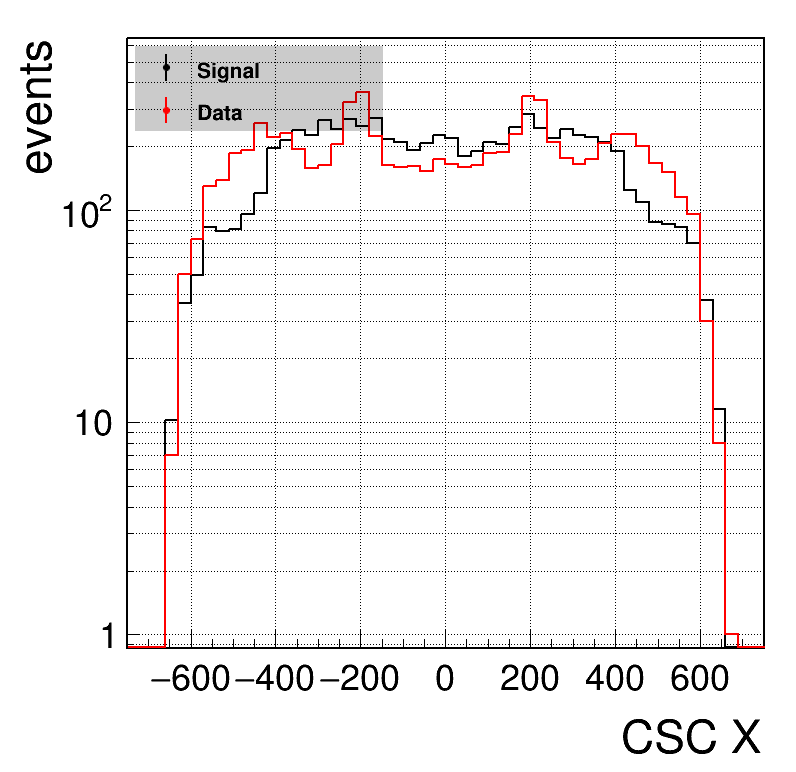

In [27]:
bins, log, norm = [50,-750, 750], True, False
axis_titles = ["CSC X", f"{'fraction of ' if norm else ''}events"]
values = [ms["cscX"] for ms in mss]

_v, _n, _w, _c = values, names, weights, colors
canvas, legend, hists = create_hists(_v, bins, _n, axis_titles, _w, _c, styles=None, log=log, norm=norm)
canvas.Draw()

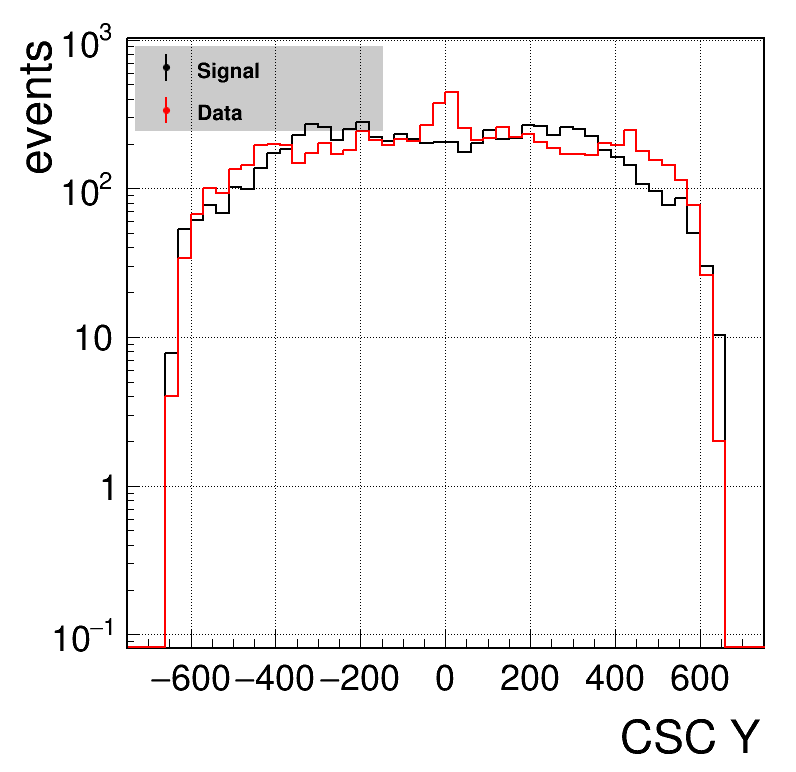

In [28]:
bins, log, norm = [50,-750, 750], True, False
axis_titles = ["CSC Y", f"{'fraction of ' if norm else ''}events"]
values = [ms["cscY"] for ms in mss]

_v, _n, _w, _c = values, names, weights, colors
canvas, legend, hists = create_hists(_v, bins, _n, axis_titles, _w, _c, styles=None, log=log, norm=norm)
canvas.Draw()

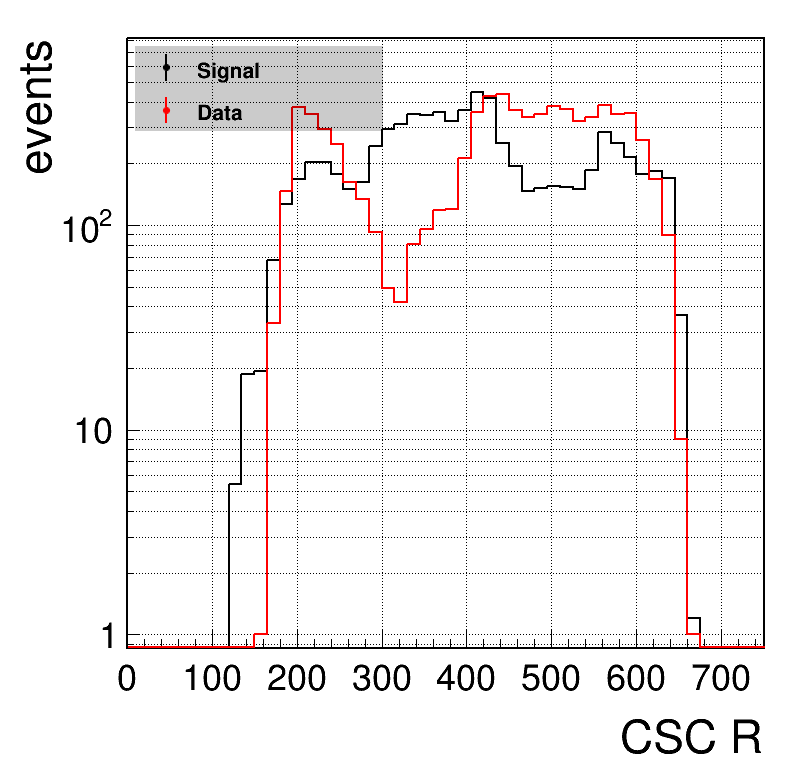

In [29]:
bins, log, norm = [50,0, 750], True, False
axis_titles = ["CSC R", f"{'fraction of ' if norm else ''}events"]
values = [ms["cscR"] for ms in mss]

_v, _n, _w, _c = values, names, weights, colors
canvas, legend, hists = create_hists(_v, bins, _n, axis_titles, _w, _c, styles=None, log=log, norm=norm)
canvas.Draw()

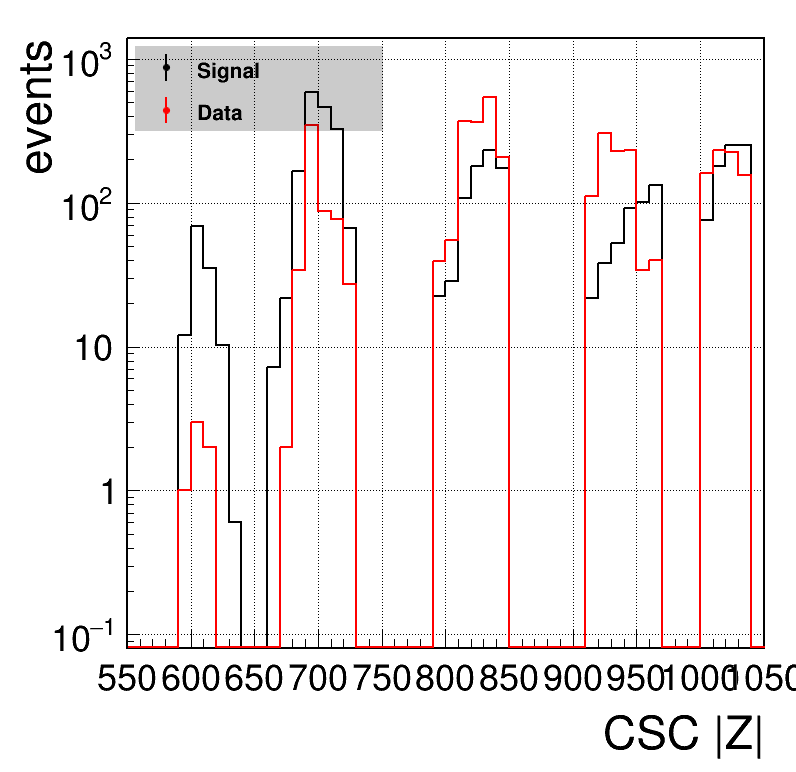

In [30]:
bins, log, norm = [50,550, 1050], True, False
axis_titles = ["CSC |Z|", f"{'fraction of ' if norm else ''}events"]
values = [ms["cscZ"] for ms in mss]

_v, _n, _w, _c = values, names, weights, colors
canvas, legend, hists = create_hists(_v, bins, _n, axis_titles, _w, _c, styles=None, log=log, norm=norm)
canvas.Draw()